# Assignment 5: Sequential Gaussian Simulation

**Note**: This notebooks is a graded assignment. It counts **25% to your final mark** in the exercise with **25 points** to be achieved! You can work on this assignment alone or together in a group of two. In the second case, it is sufficient if only one person submits the results, but please indicate clearly the name of the other person.

The notebook is **due at the 28th of August**. However, I strongly suggest that you finish it by next Thursday, so that we have the opportunity for discussion, if required, during the last exercise!

**Please add your student ID to the notebook name so that it is clearly identifiable!** I.e. if your student ID were 0123456, then for this assignment your filename should be:

    nre-assignement-4-0123456.ipynb

Please submit your assignments per email to: 
<wellmann@aices.rwth-aachen.de>

Please also add your student id here (or your ids if you submit together):

**Student ID(s): **

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
from __future__ import division
#from __future__ import print_function

In [4]:
from IPython.core.display import HTML
css_file = 'nre_style_3.css'
HTML(open(css_file, "r").read())

IOError: [Errno 2] No such file or directory: 'nre_style_3.css'

## Simulation of 1-D permeability values

This assignment is an extension of the previous two assignments where we now close the loop between kriging, experimental variogram analysis, and property simulation. We will here use the estimated correlation of the last assignment now to _simulate_ the values using Sequential Gaussian Simulation (SGS).

In the algorithm of SGS, we combine estimated mean and standard deviations with random sampling to draw a representative value for a property at an unknown location. 

Recall that the typical procedure is to:

1. Define the property space (1-D, or 2-D grid)
2. Randomly iterate through space
3. At each location, determine mean and standard deviation using kriging with local neighbourhood values
4. Draw random sample at location
5. Iterate until all positions filled.

In addition to sampling at all unknown locations, we will furthermore reuse the experimental variogram analysis from the last assignment to determine if the sampled values follow the theoretical variogram/ covariance function that was used in the kriging interpolation step to perform the sampling.

## Task 1 (5 pts): 1-D kriging with multiple values

This task is an extension of the interpolation performed in assignment 3. However, the previous implementation has to be extended to now work with an arbitrary amount of data points, but still in 1-D.

The first part is, as before, to define the covariance function. We now use an exponential model of the form:

$$ \gamma(h) = c_0 e^{( -3.0 \frac{h}{r} )} $$

where $h$ is the lag, $c_0$ the sample variance, and $r$ the covariance range.

**Your task (8 pts)**: Complete the functions below to calculate (a) the covariance function, and (b) to perform for multiple points with the simple kriging method. The kriging function should return two values (as a tuple): the estimated value and the estimated kriging variance at the unknown position:


In [4]:
# Your code here:

# (a) covariance function with arguments:
# h : lag
# r : covariance range
# sample_var : variance of sample population
def cf(x_pos, r, sample_var, info = False):
    """h = Array: lag"
    r =  Range of the spherical semivariogram
    sample_var = Nugget, variance
    """
    
    # Createing the lag vector
    i, j = np.indices((len(x_pos),len(x_pos)))
    h = np.zeros((len(x_pos),len(x_pos)))
    for l in range(len(x_pos)):
        h[i==l] = abs(x_pos[l]-x_pos)
        
    # Initializing
    C_h = np.ones_like(h)
    
    # Appliying the function
    #C_h = (h<r)*( C_o*(1-1.5*(h/r)+0.5*(h/r)**3))
    C_h = sample_var*np.e**(-3.0*h/r)
    if info == True:
        print "Our lag matrix is", h
        print "Our covariance matrix is",C_h
    return C_h

    
    
# (b) kriging interpolation with arguments:
# pos_unknown: position (float) of unknown value
# x_pos : numpy array with positions of known values (used for interpolation)
# vals : numpy array corresponding property values at known positions
# r : variogram range
# sample_mean : mean value of sample population
# sample_var : variance of sample population
#
# Note: this function should return two values: estimated value and variance
def kriging(pos_unknown, x_pos, vals, r, sample_mean = False, sample_var = 0.0005, info = False):
    
    if sample_mean == False:
        sample_mean = np.mean(vals)
    
    #Lag:
    Y = (vals-sample_mean)
    
    # Covariance matrix:
    C_h = cf(x_pos, r, sample_var, info = info)
    
    # "Interpolation point":
    b = np.zeros(len(x_pos))
    dist = abs(pos_unknown-x_pos)
    b = sample_var*np.e**(-3.0*dist/r)

    # Solving the system
    lam = np.linalg.solve(C_h, b)

    # Lag of the interpolated point
    Y_a = sum(lam*Y)

   
    sol = Y_a + sample_mean


    
    # Calculate the variance
    var = sample_var - np.sum(lam*b)
    
    
    if info == True:
        print "lag at the point", Y_a

        print "weight", lam
        print "mean solution", sol
        print "lamba*b", lam*b
        print "variance solution", var
    
    return sol, var

    

Test your implementation with the following call:

In [5]:
est_val, est_var = kriging(500, np.array([490, 501, 510, 492]), 
                           np.array([0.2, 0.3, 0.3, -0.2]), 120, 0.1, 3.0, info = True)
print(est_val, est_var)

Our lag matrix is [[  0.  11.  20.   2.]
 [ 11.   0.   9.   9.]
 [ 20.   9.   0.  18.]
 [  2.   9.  18.   0.]]
Our covariance matrix is [[ 3.          2.27871637  1.81959198  2.85368827]
 [ 2.27871637  3.          2.39554866  2.39554866]
 [ 1.81959198  2.39554866  3.          1.91288445]
 [ 2.85368827  2.39554866  1.91288445  3.        ]]
lag at the point 0.144407007917
weight [ -1.48029737e-16   8.87320934e-01  -5.33134442e-16   1.10190596e-01]
mean solution 0.244407007917
lamba*b [ -3.45857024e-16   2.59623871e+00  -1.24561656e-15   2.70649289e-01]
variance solution 0.133112004898
(0.24440700791719719, 0.13311200489811048)


As a self-test: the previous function should yield the result (some trailing digits may deviate):

     0.244407007917 0.133112004898 

## Task 2 (15 pts): Sequential Gaussian Simulation

We can now use this function to perform the simulation. However, before we can get started, we need to define a model range on which to perform the sampling, as well as the random path to visit each position in the range. 

One possibility to get the random path is to first define the values (e.g. with the `np.arange` function) and then to use the `np.random.shuffle` method to shuffle the values around in-place. Motivated from the real data that we analysed in assignment 4, we are using a range from 200 to 1600 m.

Also, following up from assignment 4, we will use the following settings for the experimental variogram:

* $r$ = 120 (variogram range)
* $c_0$ = 0.3 (population variance)

**Your task (1 pt)**: In order to make the following results reproducible, the first step will be to define the random seed. Use your student id in the `np.random.seed(student_id)` function to initiate the seed:

In [6]:
# Your code: set the seed
np.random.seed(382421)

**Your task (1 pts)**: Define sampling positions in the range from 200 to 1600 m, with one sample per meter, and randomise the positions:

In [7]:
# Your code here:
values = np.arange(200,1600)
np.random.shuffle(values)
print values, len(values)

[1000 1041  829 ..., 1062 1085  798] 1400


We now have a lot of data points to simulate values at. Recall from the lecture, that we usually only use a defined number of nearest points to perform the kriging estimation (otherwise, we would end up using more than 1000 points in the final steps!). One possibility to implement this functionality in your code is to (at each sample location):

1. Calculate the distance between the unknown point and all previously sampled points and store the result in an array;
2. Use this distance array to sort the arrays of the previously sampled positions and their values (see: the `np.argsort` method!) to sort these arrays according to the distance to the unknown point;
3. Use only the previous $n$ elements of these arrays in the interpolation step (see `x_pos` and `vals` arguments in the kriging function above).

After performing the kriging, you obtain estimated value and variance. In order to simulate a value you can draw from the normal distribution with these parameters, for example with the function:

    np.random.normal(value, stdev) 
    
*Note: don't forget to transform variance into standard deviation, first!*

**Your task (12 pts)**: Write now the code to perform the sampling at each of these positions, using the $n = 20$ nearest values. Use $r = 120$ and $c_0 = 0.3$ as variogram parameters, as well as 0.0 for the sample mean (residuals only). Finally, store the sampled value in a numpy array (e.g. `sampled_vals`):

In [9]:
np.argmax?

In [10]:
n = 5
idx = np.where((np.abs(data[:,0]-values[9])< (np.sort(np.abs(data[:,0]-values[9]))[n])))
print idx, values
print np.sort(np.abs(data[:,0]-values[9]))[n], values[9]
print data[idx,0]

lala = np.vstack([data, [2,3,0]])
lala

NameError: name 'data' is not defined

In [11]:
np.array([[490, 501, 510, 492],[0.2, 0.3, 0.3, -0.2]]).transpose()

array([[  4.90000000e+02,   2.00000000e-01],
       [  5.01000000e+02,   3.00000000e-01],
       [  5.10000000e+02,   3.00000000e-01],
       [  4.92000000e+02,  -2.00000000e-01]])

In [8]:
# Your code here:
def SGS(x_min, x_max, x_pos, values, r, sample_mean = False, sample_var = 0.0005, info = False, n = 20):
    # Creating the "1D-grid"
    Positions_unknown = np.arange(x_min,x_max)
    np.random.shuffle(Positions_unknown)
    # Setting the data matrix
    data = np.array([x_pos,values]).transpose()
   # print data
    sampled_vals = []
    i = 1
    for pos_unknown in Positions_unknown:
        # Finding the index of the closest values:
        if n> len(data):
            n = len(data)
            
        idx = np.where((np.abs(data[:,0]-pos_unknown)<=(np.sort(np.abs(data[:,0]-pos_unknown))[n-1])))
        
        nearest_pos = np.squeeze(data[idx,0])  # depth
        nearest_val = np.squeeze(data[idx,1])  # permeability
    #    print nearest_pos, data[idx,1]
        i += 1
        
        krig_mean, krig_var = kriging(pos_unknown, nearest_pos, nearest_val, r = r
                                ,sample_mean = sample_mean, sample_var = sample_var, info = info)
        #print i , krig_mean, krig_var
        try:
            simulated_val = np.random.normal(krig_mean, np.sqrt(krig_var))
            data = np.vstack([data,[pos_unknown, simulated_val]])
        except ValueError:
            continue
        # Appending the simulated value and at the correct depth
        
        sampled_vals = np.append(sampled_vals, simulated_val)
        
    return data



In [10]:
sim_data = SGS(200, 1600, np.array([490, 501]), np.array([0.2, 0.3]), 120, sample_var = 0.3, n = 20, info = False)


Finally, we want to compare the sampled/ simulated values to the actually measured values that we previously used in assignment 4. A quick way to compare the results is, of course, to plot the values with depth. 

*Note: If you want to show the data as a line plot (you don't have to!), you will have to sort the arrays before plotting. Recall the `np.argsort` method from above for a possible way to do this!*

**Your task (2 pts)**: Create a plot of simulated values:

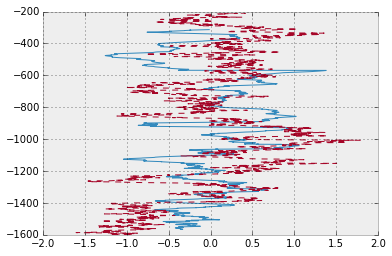

In [12]:
# Your code here:
# Sorting values:
sim = sim_data
sim = sim[sim[:,0].argsort()]

# data from assignment 4
data = np.loadtxt("ASCOut_W20.asc", skiprows = 3)
bolean_array = data[:,1]>0
data = data[bolean_array]
data[:,1] = np.log10(data[:,1])
coefficients = np.polyfit(data[:,0],data[:,1],1)
polynomial = np.poly1d(coefficients)
ys = polynomial(data[:,0])
data[:,1] = data[:,1]-ys

#Plotting
plt.plot(data[:,1], -data[:,0], linewidth=1)
plt.plot(sim[:,1], -sim[:,0],  "--",linewidth=1)



What do you think, is the simulated dataset comparable to the measured (de-trended) data?

## Task 3 (5 pts): Calculate experimental variogram

The direct link between the simulated and the measured data is given in the form of the (exponential) covariance function and the two parameters that we interpreted from the experimental variogram in assignment 4. Considering this link, it is interesting to now determine the experimental variogram from the simulated data set. Do you expect to get back the form of the theoretical variogram?

**Your task (3 pts)**: Determine experimental variogram from simulated data and create a plot with lags and tolerance levels given below:

In [29]:
lags = np.arange(10.,500.,10.)
tol = 10.

# Your code here:

# Functions:
def extract(data, d,lag,tol):
    return data[((data[:,0] < (d-lag+tol)) * (data[:,0] > (d-lag-tol))) + ((data[:,0] < (d+lag+tol)) * (data[:,0] > d+lag-tol))] 

def semivariance_h(data,d,lag,tol):
    idx = (np.abs(data[:,0]-d)).argmin()
    u_alpha = (extract(data,d,lag,tol)[:,1])  
    return   (u_alpha- data[idx,1])**2


# Performing semivariance of the simulation data
points = []
semivariance_lag_sim = []
for j in lags:
    for i in sim_data[:,0]:        
        points = np.append(points,semivariance_h(sim_data,i,j,tol))

    semivariance_lag_sim = np.append(semivariance_lag, np.mean(points)) 
    
     # Reset points
    points = []
    
    
# Performing semivariance of the data
points = []
semivariance_lag = []
for j in lags:
    for i in data[:,0]:        
        points = np.append(points,semivariance_h(data,i,j,tol))

    semivariance_lag = np.append(semivariance_lag, np.mean(points)) 
    
     # Reset points
    points = []    


Do the retrieved experimental variogram values look like you expected from the theoretical variogram? 

**Your task (2 pts)**: Plot the theoretical variogram over the values and discuss the results (how would it be possible to get a better esimate?):

[ 0.11424085  0.20161098  0.26295878  0.30502035  0.33349908  0.35304121
  0.37896264  0.41103395  0.43756155  0.4496258   0.45174198  0.45002339
  0.44401293  0.45000762  0.47260156  0.49211612  0.49817462  0.50011302
  0.48733919  0.46846885  0.46432972  0.46472607  0.45543271  0.43690667
  0.41374332  0.38418736  0.35874349  0.34431588  0.3458389   0.36594178
  0.40435121  0.44646292  0.47615131  0.49554683  0.51589274  0.53520627
  0.54870129  0.55433465  0.55157816  0.5473168   0.54831647  0.55119661
  0.55267821  0.55418996  0.56096083  0.57111628  0.5663166   0.55127334
  0.54141285  0.54141285] 49 [ 0.10707721  0.23252377  0.33013417  0.37019033  0.38282693  0.40527416
  0.44249302  0.48571103  0.52146125  0.54425441  0.55952925  0.57409433
  0.59308544  0.6062589   0.60499632  0.59778241  0.60151469  0.61099146
  0.59860308  0.54969855  0.48381123  0.4429232   0.44896204  0.49644263
  0.53876327  0.54025611  0.52371831  0.5291057   0.55937726  0.58723022
  0.5981539   0.606615

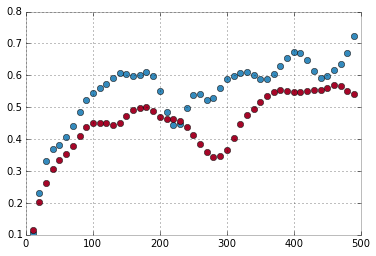

In [41]:
print semivariance_lag_sim, len(lags), semivariance_lag
# Your code here:
plt.plot(lags, semivariance_lag, "o")
plt.plot(lags, semivariance_lag_sim[:-1], "o")

In this assignment, you went through the entire loop of using an experimental variogram to simulate values at unknown locations on the basis of kriging interpolation with the Sequential Gaussian Simulation (SGS) algorithm!

I hope that you also realised possible advantages (in simulating the variability), but also limitations (in obtaining the correct correlations) of the approach - and that you get a feeling for potential pitfalls when you use these methods in the future, for example implemented in some software packages.

## Bonus task (5 pts): SGS on 2-D fields

The extension to 2-D fields is conceptually not difficult, it only requires some care when calculating the distance between points, and the definition of the random path. However, as it is an additional good practice in the use of the previously learned methods, I am giving up to 5 bonus points for simulation and visualisation of a random field with SGS on a 2-D grid!

**Your (bonus) task (5 pts)**: Extend your methods above to perform SGS on a 2-D grid, simulate and visualise a grid with parameters of your choice:

In [ ]:
# Your code:

